In [1]:
CUDA_LAUNCH_BLOCKING=1
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision import datasets, models, transforms

import PIL
from PIL import Image

import math
import random
import seaborn as sn
import pandas as pd
import numpy as np
from pathlib import Path
from skimage import io
import pickle
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm, tqdm_notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Ignore warnings

import warnings
warnings.filterwarnings("ignore")

print("PyTorch Version: ", torch.version)
print("Torchvision Version: ", torchvision.version)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available. Training on CPU …')
else:
  print('CUDA is available! Training on GPU …')

PyTorch Version:  <module 'torch.version' from '/usr/local/lib/python3.7/dist-packages/torch/version.py'>
Torchvision Version:  <module 'torchvision.version' from '/usr/local/lib/python3.7/dist-packages/torchvision/version.py'>
CUDA is available! Training on GPU …


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
!unzip -q /content/gdrive/My\ Drive/journey-springfield.zip

In [4]:
!nvidia-smi
import torch
torch.cuda.is_available()

Thu Nov 17 07:49:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

# Работа с данными

In [5]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [6]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [8]:
TRAIN_DIR = Path('journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [9]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

In [10]:
val_dataset = SimpsonsDataset(val_files, mode='val')

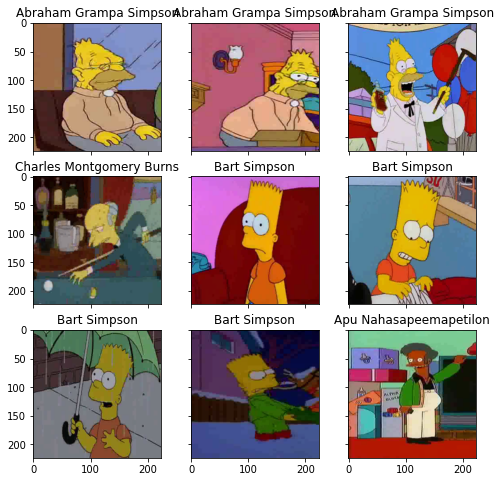

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [12]:
n_classes = len(np.unique(train_val_labels))
print("we will classify :{}".format(n_classes))

we will classify :42


In [13]:
pd.Series(train_val_labels).value_counts().sort_values().to_frame("count")

,count
lionel_hutz,3
troy_mcclure,8
disco_stu,8
miss_hoover,17
gil,27
fat_tony,27
otto_mann,32
sideshow_mel,40
agnes_skinner,42
rainier_wolfcastle,45


Из таблицы можно заметить, что классы в обучаемой выборке несбалансированы. Для решения данной проблемы предлагается искусственно дополнить новыми данными, основанными на старых. Идея с использованием augmentations была взята из [данного ноутбука](https://www.kaggle.com/code/marinalakeeva/data-augmentation) 

In [14]:
augmentations = transforms.RandomChoice([
    transforms.Compose([
        transforms.Resize(size=300, max_size=301),
        transforms.CenterCrop(size=300),
        transforms.RandomCrop(250)
    ]),
    transforms.RandomRotation(degrees=(-25, 25)),
    transforms.RandomHorizontalFlip(p=1),
])
train_transforms = transforms.Compose([
    augmentations,
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
])
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)

In [15]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

In [16]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = F.softmax(outputs, dim=-1).argmax(-1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [17]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects / processed_size
    return val_loss, val_acc

In [18]:
def train(model, criterion, optimizer, scheduler, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            scheduler.step()
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            if val_acc == max(list(map(lambda x: x[-1], history))):
                model_name = f'simpsons_vgg16_pretrained_epoch{epoch}.h5'
                torch.save(model, model_name)
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [19]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [20]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

# Выбор модели

Для обучения модели из всех испробованных была выбрана модель VGG16 с заморозкой первых нескольких слоёв

In [21]:
# Ваш код здесь
model_extractor = models.vgg16(pretrained=True)

layers_to_unfreeze = 5

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_extractor.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, 42)

# Использовать ли GPU
if train_on_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификат
optimizer = optim.SGD(list(model_extractor.features.parameters())[-layers_to_unfreeze:] + 
                      list(model_extractor.classifier.parameters()), lr=0.001, momentum=0.9)
# optimizer = optim.SGD(model_extractor.classifier.parameters(), lr=0.001, momentum=0.9)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [23]:
hystory = train(model_extractor, loss_fn, optimizer, exp_lr_scheduler, 15, 64)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 1.2358042336834865


epoch:   7%|▋         | 1/15 [04:50<1:07:42, 290.16s/it]


Epoch 001 train_loss: 1.2358     val_loss 0.4896 train_acc 0.6802 val_acc 0.8752
loss 0.5048571412552959


epoch:  13%|█▎        | 2/15 [09:30<1:01:39, 284.61s/it]


Epoch 002 train_loss: 0.5049     val_loss 0.2914 train_acc 0.8656 val_acc 0.9222
loss 0.339647365083439


epoch:  20%|██        | 3/15 [14:10<56:27, 282.30s/it]


Epoch 003 train_loss: 0.3396     val_loss 0.1862 train_acc 0.9093 val_acc 0.9490
loss 0.2453478800754583


epoch:  27%|██▋       | 4/15 [18:51<51:41, 281.99s/it]


Epoch 004 train_loss: 0.2453     val_loss 0.1334 train_acc 0.9345 val_acc 0.9662
loss 0.18495264736984346


epoch:  33%|███▎      | 5/15 [23:28<46:40, 280.06s/it]


Epoch 005 train_loss: 0.1850     val_loss 0.1112 train_acc 0.9505 val_acc 0.9696
loss 0.12070109312007164


epoch:  40%|████      | 6/15 [28:05<41:51, 279.04s/it]


Epoch 006 train_loss: 0.1207     val_loss 0.0736 train_acc 0.9675 val_acc 0.9830
loss 0.10715880551279483


epoch:  47%|████▋     | 7/15 [33:00<37:54, 284.27s/it]


Epoch 007 train_loss: 0.1072     val_loss 0.0683 train_acc 0.9719 val_acc 0.9845
loss 0.10389732542975272


epoch:  53%|█████▎    | 8/15 [37:45<33:10, 284.34s/it]


Epoch 008 train_loss: 0.1039     val_loss 0.0623 train_acc 0.9732 val_acc 0.9866
loss 0.09967726518050807


epoch:  60%|██████    | 9/15 [42:29<28:26, 284.37s/it]


Epoch 009 train_loss: 0.0997     val_loss 0.0594 train_acc 0.9748 val_acc 0.9866
loss 0.09567693120614032


epoch:  67%|██████▋   | 10/15 [47:11<23:38, 283.64s/it]


Epoch 010 train_loss: 0.0957     val_loss 0.0552 train_acc 0.9748 val_acc 0.9874
loss 0.09065556207257376


epoch:  73%|███████▎  | 11/15 [51:53<18:51, 282.97s/it]


Epoch 011 train_loss: 0.0907     val_loss 0.0539 train_acc 0.9767 val_acc 0.9880
loss 0.08699097279001429


epoch:  80%|████████  | 12/15 [56:34<14:07, 282.39s/it]


Epoch 012 train_loss: 0.0870     val_loss 0.0513 train_acc 0.9792 val_acc 0.9882
loss 0.07993165582352328


epoch:  87%|████████▋ | 13/15 [1:01:14<09:23, 281.93s/it]


Epoch 013 train_loss: 0.0799     val_loss 0.0498 train_acc 0.9806 val_acc 0.9887
loss 0.08133592985465589


epoch:  93%|█████████▎| 14/15 [1:05:55<04:41, 281.64s/it]


Epoch 014 train_loss: 0.0813     val_loss 0.0494 train_acc 0.9793 val_acc 0.9887
loss 0.0768127380486106


epoch: 100%|██████████| 15/15 [1:10:37<00:00, 282.53s/it]


Epoch 015 train_loss: 0.0768     val_loss 0.0489 train_acc 0.9813 val_acc 0.9895


# **Submit на Kaggle**

In [42]:
best_model = torch.load('/content/simpsons_vgg16_pretrained_epoch14.h5')

In [43]:
best_model  

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [38]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(best_model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('gdrive/My Drive/simpsons_simple_cnn_baseline.csv', index=False)

**Team name: Elizaveta_Shpilko**
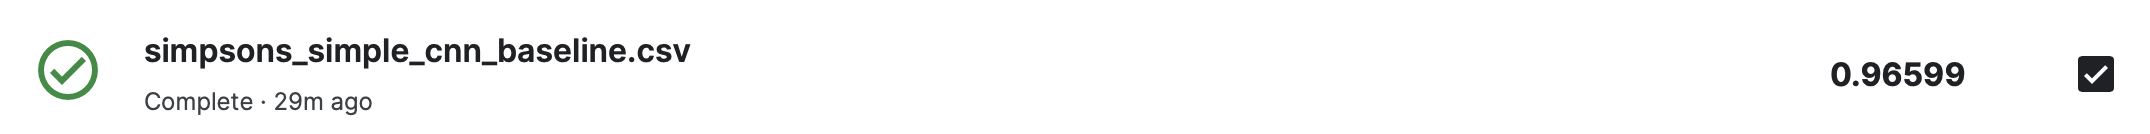